### 1.1配置工作路径

In [1]:
import os, sys
import torch, json
from markdown.postprocessors import Postprocessor

from src.data import mscoco_category2label

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

/root/anaconda3/envs/exp_1/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### 1.2导入模型

In [2]:
from src.core import YAMLConfig
from src.solver.distill_solver import DistillSolver

model_config_path = "../configs/rtdetrv2_distill/rtdetrv2_r101vd_distill_to_rtdetrv2_r50vd.yml" # change the path of the model config file
args_dict = {
    "resume": "../output/rtdetrv2_r101vd_distill_to_rtdetrv2_r50vd_vfl/checkpoint0000.pth",
    "teacher_resume": "../resumes/rtdetrv2_r101vd_6x_coco_from_paddle.pth",
    "seed": 42,
}

cfg = YAMLConfig(model_config_path, **args_dict)

solver = DistillSolver(cfg)
solver.visualize()

model = solver.model
model.eval()

teacher = solver.teacher
teacher.eval()

postprocessor = solver.postprocessor

Load PResNet50 state_dict
Load PResNet101 state_dict
building train_dataloader with batch_size=16...
loading annotations into memory...
Done (t=33.11s)
creating index...
index created!
building val_dataloader with batch_size=32...
loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
Resume teacher checkpoint from ../resumes/rtdetrv2_r101vd_6x_coco_from_paddle.pth


/root/detection/kd_for_rtdetr/src/solver/_solver.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location='cpu')


Number of missed keys: 0, Number of unmatched keys: 0
Number of matched parameters: 76820078
Resume checkpoint from ../output/rtdetrv2_r101vd_distill_to_rtdetrv2_r50vd_vfl/checkpoint0000.pth


/root/detection/kd_for_rtdetr/src/solver/_solver.py:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location='cpu')


Load model.state_dict, {'missed': [], 'unmatched': []}


## 2.COCO数据集导入

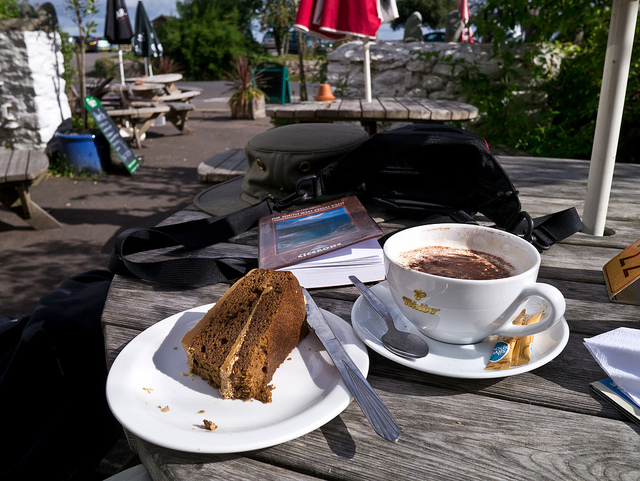

In [111]:
data_loader = solver.train_dataloader
dataset = data_loader.dataset

image, target = dataset.load_item(23)
image.show()

import copy
img = image.copy()
tgt = copy.deepcopy(target)

In [112]:
import torchvision.transforms.v2.functional as F
from src.data.transforms._transforms import ConvertBoxes
from src.data.dataset.coco_dataset import mscoco_category2name

image = F.pil_to_tensor(image)
image = image.float()
image = image/255

box_converter = ConvertBoxes('cxcywh', normalize=True)
image, target, _ = box_converter(image, target, box_converter)

id2name = [v for _,v in mscoco_category2name.items()]

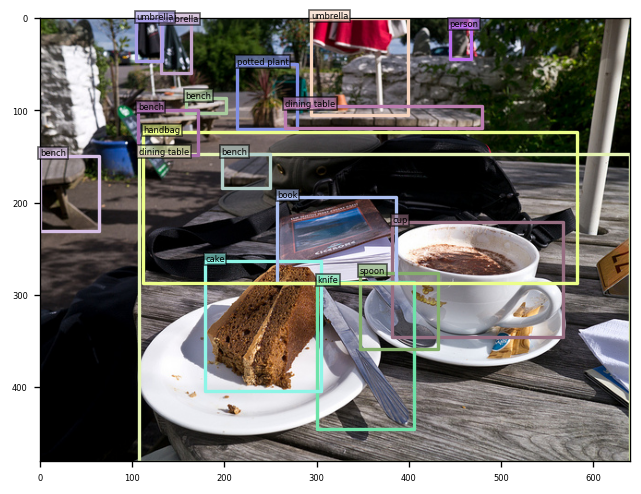

In [113]:
# build gt_dict for vis
from src.misc.coco_visualizer import COCOVisualizer

box_label = [id2name[int(item)] for item in target['labels']]
gt_dict = {
    'boxes': target['boxes'],
    'image_id': target['image_id'],
    'size': torch.tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None, normalized_before=False)

In [114]:
val_dataset = solver.val_dataloader.dataset
img, tgt, _ = val_dataset._transforms(img, tgt, val_dataset)

output = model.cuda()(img.cuda())
t_output = teacher.cuda()(img.cuda())

result = postprocessor(output, tgt['orig_size'].cuda())[0]
t_result = postprocessor(t_output, tgt['orig_size'].cuda())[0]

print(output['pred_boxes'])
print(output['pred_logits'])
print(t_output['pred_boxes'])
print(t_output['pred_logits'])

tensor([[[0.5977, 0.6032, 0.2479, 0.3128],
         [0.5741, 0.5548, 0.2067, 0.2138],
         [0.5517, 0.5817, 0.1924, 0.2707],
         ...,
         [0.4550, 0.2615, 0.1578, 0.1389],
         [0.5028, 0.5126, 0.1915, 0.2279],
         [0.5000, 0.5249, 0.2681, 0.2669]]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[[-1.7472, -2.8115, -2.4338,  ..., -2.2599, -3.4242, -2.4449],
         [-2.6564, -4.0289, -3.4992,  ..., -3.0514, -4.2696, -3.1144],
         [-2.4369, -3.6110, -3.3924,  ..., -2.5478, -3.8021, -2.8179],
         ...,
         [-4.1434, -6.3245, -4.6214,  ..., -5.3314, -6.2265, -5.4266],
         [-4.0240, -5.6622, -4.3781,  ..., -4.6607, -5.3138, -4.6658],
         [-4.3286, -6.0386, -4.6719,  ..., -5.1063, -5.5369, -5.0631]]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[[0.7411, 0.5899, 0.2906, 0.2556],
         [0.3823, 0.6974, 0.2017, 0.2796],
         [0.2296, 0.0806, 0.0514, 0.1567],
         ...,
         [0.6014, 0.1091, 0.3020, 0.213

In [131]:
import torchvision

thershold = 0.2
# set a thershold

scores = result['scores']
labels = result['labels']
boxes = result['boxes']
boxes = torchvision.ops.box_convert(result['boxes'], in_fmt='xyxy', out_fmt='cxcywh')
select_mask = scores > thershold

['cup', 'cup']
tensor([0, 2], device='cuda:0')


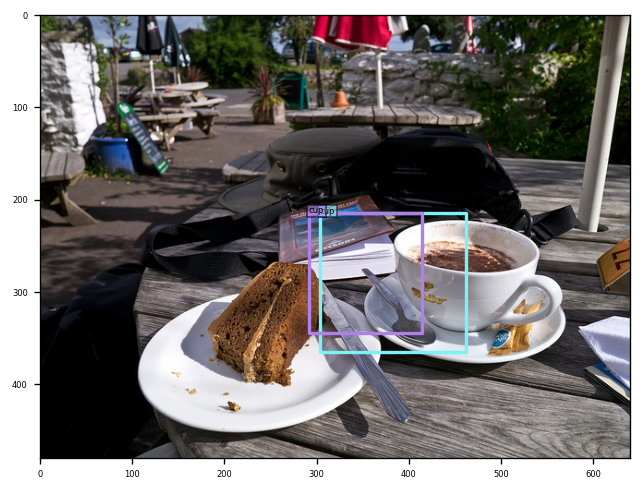

In [132]:
box_label = [id2name[mscoco_category2label[int(item)]] for item in labels[select_mask]]
print(box_label)
print(result['indices'][select_mask])
pred_dict = {
    'boxes': (boxes[select_mask].cpu()/tgt['orig_size'].repeat(1, 2).unsqueeze(1))[0],
    'size': torch.tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, normalized_before=False)

In [133]:
t_scores = t_result['scores']
t_labels = t_result['labels']
t_boxes = t_result['boxes']
t_boxes = torchvision.ops.box_convert(t_result['boxes'], in_fmt='xyxy', out_fmt='cxcywh')
t_select_mask = t_scores > thershold

['spoon', 'cup', 'cake', 'knife', 'handbag', 'umbrella', 'umbrella', 'bench', 'dining table', 'dining table', 'book', 'umbrella', 'bench', 'bench', 'bench', 'bench', 'dining table', 'dining table', 'potted plant', 'umbrella', 'handbag', 'potted plant', 'umbrella', 'person', 'dining table', 'potted plant', 'book', 'dining table', 'bench', 'cell phone', 'potted plant', 'umbrella', 'book', 'chair', 'chair', 'handbag', 'person', 'dining table', 'dining table', 'dining table', 'backpack', 'person', 'book', 'bench', 'bench', 'potted plant', 'dining table', 'chair', 'bench', 'dining table', 'bench', 'dining table', 'bench', 'dining table', 'bench', 'backpack', 'umbrella']
tensor([  3,   0,   1,   7,  53,   2,  14,   8,   6, 199,   9,  13,  12,  19,
         15,  41,  20,  23,  17,   5,   4,  32,  16,  11,  51,  33,  70,  90,
        182,  39,  69,  35,  29,  43,  26,  57,  24,  31, 127, 192,   4, 134,
        113, 103, 145, 260,  41,  46, 167, 174, 166,  48,  85,  56,  83, 171,
         58], 

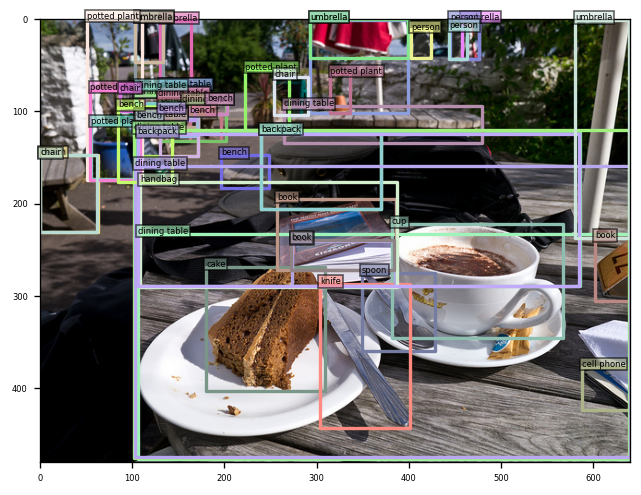

In [134]:
from src.data.dataset.coco_dataset import mscoco_category2label
t_box_label = [id2name[mscoco_category2label[int(item)]] for item in t_labels[t_select_mask]]
print(t_box_label)
print(t_result['indices'][t_select_mask])
t_pred_dict = {
    'boxes': (t_boxes[t_select_mask].cpu() / tgt['orig_size'].repeat(1, 2).unsqueeze(1))[0],
    'size': torch.tensor([image.shape[1], image.shape[2]]),
    'box_label': t_box_label
}
vslzr.visualize(image, t_pred_dict, savedir=None, normalized_before=False)